# Importance sampling with feedforward neural networks

In [1]:
import sys
import time

import pandas as pd

import numpy as np
from numpy import savetxt, loadtxt

import matplotlib.pyplot as plt

from scipy import integrate
from scipy.stats import norm

from tqdm.notebook import trange
from cycler import cycler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers, regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Subtract, Multiply, Concatenate
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

np.random.seed(2023)
tf.random.set_seed(2023)


2023-06-02 13:26:45.345966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python version:  3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]
Tensorflow version:  2.10.0
Keras version:  2.10.0


In [2]:
N_train = 250       # Number of time steps for training
N_test = 250        # Number of time steps for testing

###### Magnitude of time change
kappa = 10.0

################################################################################

n_hidden = 1          # Number of hidden layers for deep neural network
n_nodes = 2           # Number of nodes in hidden layers
batchsize = 1024      # Batch size
learningrate = 1.0e-3 # Learning rate for Adam (standard 1e-3)

N_NN_train = int(2 * 100 * batchsize)  # Size of training/validation data set for neural network
N_NN_test = int(1.0e5)                 # Size of testing data set for neural network

################################################################################
##### Further model parameters

T = 1           # Terminal time

X0 = 50         # Initial price of asset
mu = 0.05       # Appreciation rate
sigma = 0.25    # Volatility

strike = 70.0   # Strike for the call option

################################################################################

delta_t_train = T/N_train         # Time increments for training
delta_t_test = T/N_test           # Time increments for testing

t_train = np.linspace(0, T, N_train+1)
t_test = np.linspace(0, T, N_test+1)


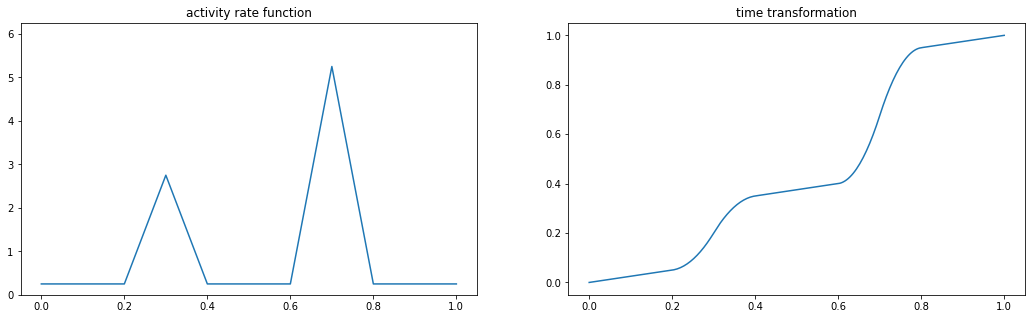

In [3]:
################################################################################
##### Defining activity rate function
def a_initial(u):
    if 0.2 <= u < 0.3:
        return 1 + (u-0.2) / 0.1 * kappa
    elif 0.3 <= u < 0.4:
        return 1 + (0.4-u) / 0.1 * kappa
    elif 0.6 <= u < 0.7:
        return 1 + (u-0.6) / 0.1 * 2 * kappa
    elif 0.7 <= u < 0.8:
        return 1 + (0.8-u) / 0.1 * 2 * kappa
    else:
        return 1

a_const = integrate.quad(a_initial, 0, T)[0]

def a(u):
    return a_initial(u) / a_const

vec_a_train = np.empty((N_train+1))
vec_a_test = np.empty((N_test+1))

for i in range(len(vec_a_train)):
    vec_a_train[i] = a(t_train[i])
for i in range(len(vec_a_test)):
    vec_a_test[i] = a(t_test[i])

vec_A_helper_train = np.empty((N_train))
vec_A_helper_test = np.empty((N_test))

for i in range(len(vec_A_helper_train)):
    vec_A_helper_train[i] = integrate.quad(a, t_train[i], t_train[i+1])[0]
for i in range(len(vec_A_helper_test)):
    vec_A_helper_test[i] = integrate.quad(a, t_test[i], t_test[i+1])[0]

vec_A_train = np.cumsum(np.concatenate([np.zeros((1)), vec_A_helper_train]))
vec_A_test = np.cumsum(np.concatenate([np.zeros((1)), vec_A_helper_test]))

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(t_test, vec_a_test)
ax[0].set_title("activity rate function")
ax[0].set_ylim([0.0, np.max(vec_a_test)+1.0])
ax[1].plot(t_test, vec_A_test)
ax[1].set_title("time transformation")
ax[1].set_ylim([-0.05, 1.05])

plt.show()

## Plotting sample path

In [4]:
M = np.sqrt(vec_A_helper_test) * np.random.normal(0, 1, (N_test))
M = np.concatenate([np.zeros((1)), M])
M = np.cumsum(M)
A = (mu - sigma**2/2) * vec_A_test
X = X0 * np.exp(A + sigma * M)


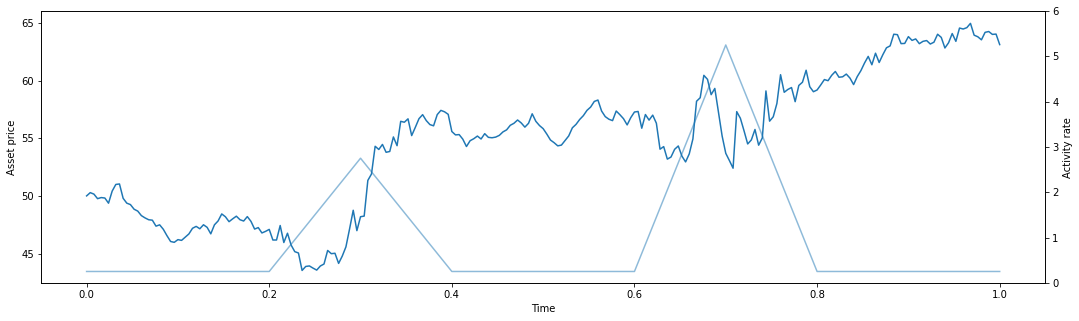

In [5]:
xlim_lower = np.floor(np.min(X[:])/10)*10
xlim_upper = np.ceil(np.max(X[:])/10)*10

fig, ax1 = plt.subplots(figsize = (18, 5))

ax2 = ax1.twinx()
ax1.plot(t_test, np.transpose(X))
ax2.plot(t_test, vec_a_test, alpha=0.5)

ax2.set_ylim([0, 6])

ax1.set_xlabel('Time')
ax1.set_ylabel('Asset price')
ax2.set_ylabel('Activity rate')

plt.show()

## Computing option price

In [6]:
start_time = time.time()

M = np.sqrt(vec_A_helper_test) * np.random.normal(0, 1, (N_NN_test, N_test))
M = np.concatenate([np.zeros((N_NN_test, 1)), M], axis = 1)
M = np.cumsum(M, axis = 1)
A = (mu - sigma**2 / 2) * vec_A_test
X = X0 * np.exp(A + sigma * M)

average = np.sum(X[:, :N_test] * delta_t_test, axis=1)/T
payoffs = 100*np.clip(average-strike, 0, None)
counter = np.sum(average-strike >= 0)

elapsed_time = time.time() - start_time

mean_mc = np.mean(payoffs)
var_MC = np.var(payoffs)
stderr_mc = np.std(payoffs) / np.sqrt(N_NN_test)
second_moment_mc = np.mean(np.power(payoffs, 2))

print("Computing time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("========================================")

print("Mean (MC): ", np.around(mean_mc, 4))
print("Second moment (MC): ", np.around(second_moment_mc, 4))
print("Variance (MC): ", np.around(var_MC, 4))

print("========================================")

print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% of mean)")
print("Probability of positive payoff (MC): ", np.around(counter / N_NN_test * 100, 2), "%")


Computing time:  00:00:01
Mean (MC):  2.5877
Second moment (MC):  1830.2923
Variance (MC):  1823.5961
Standard error (MC):  0.135  ( 5.22 % of mean)
Probability of positive payoff (MC):  0.73 %


## Input data for NN training

In [7]:
xtrain = ([np.zeros((N_NN_train))] + # t_0
          [X0*np.ones((N_NN_train))] + # X_0
          [np.zeros((N_NN_train))] + # initial value of the payoff
          [np.zeros((N_NN_train))] + # initial value of the first part of the stoch exp
          [np.zeros((N_NN_train))] + # initial value of the second part of the stoch exp
          [np.random.normal(0, 1, (N_NN_train)) for i in range(N_train)]) # increments N(0,1)

ytrain = np.zeros((N_NN_train))

## Generating neural network

In [8]:
layers = []

layers += [Dense(n_nodes, activation='tanh', trainable=True, input_shape=(1, ))]

for i in range(n_hidden-1):
    layers += [Dense(n_nodes, activation='tanh', trainable=True)]

layers += [Dense(1, activation='linear', trainable=True)]


In [9]:
t_0 = Input(shape=(1, ))
X_0 = Input(shape=(1, ))

c_0 = Input(shape=(1, ))
c_1 = Input(shape=(1, ))
c_2 = Input(shape=(1, ))
 
inputs = [t_0]+[X_0]+[c_0]+[c_1]+[c_2]

t_current = t_0
X_current = X_0

for j in range(N_train):
    
    c_0_helper = X_current * delta_t_train
    c_0 = Add()([c_0, c_0_helper])
    
    strategy = t_current
    for i in range(n_hidden+1):
        strategy = layers[i](strategy)
    
    incr_B = Input(shape=(1, ))
    inputs = inputs + [incr_B]
    
    incr_M = np.sqrt(vec_A_helper_train[j]) * incr_B

    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy]) * vec_A_helper_train[j]
    c_2 = Add()([c_2, helper_e2])
    
    t_current = t_current + delta_t_train
    
    helper_drift = mu * X_current * vec_a_train[j] * delta_t_train
    helper_diffusion = sigma * Multiply()([X_current, incr_M])
    
    helper_X = Add()([helper_drift, helper_diffusion])
    X_current = Add()([X_current, helper_X])

helper_e5 = -0.5 * c_1
helper_e6 = 0.25 * c_2

helper_e7 = Add()([helper_e5, helper_e6])
helper_e8 = Lambda(lambda x: K.exp(x))(helper_e7)

payoff = 100 * Lambda(lambda x: K.relu(x-strike))(c_0)

payoff_adjusted = Multiply()([payoff, helper_e8])
 
outputs = [payoff_adjusted]


2023-06-02 13:26:55.682272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
opt = optimizers.Adam(learning_rate = learningrate)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=opt, loss='mean_squared_error')


In [11]:
indices_list = []

for i in range(len(model.layers)):
    layer_train_size = len(model.layers[i].get_weights())
    if layer_train_size > 0:
        indices_list += [i]

## Training the neural network

In [12]:
stopping_rule = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=1, 
                              restore_best_weights=True)

In [13]:
start_time = time.time()

history = model.fit(x=xtrain,
                    y=ytrain,
                    epochs=1000,
                    verbose=1,
                    shuffle=True,
                    batch_size=batchsize,
                    validation_split=0.5,
                    callbacks=[stopping_rule])

elapsed_time = time.time() - start_time

Epoch 1/1000
100/100 [==============================] - 52s 179ms/step - loss: 758.9528 - val_loss: 470.8491
Epoch 2/1000
100/100 [==============================] - 3s 30ms/step - loss: 423.1093 - val_loss: 314.1515
Epoch 3/1000
100/100 [==============================] - 3s 31ms/step - loss: 295.9943 - val_loss: 237.3073
Epoch 4/1000
100/100 [==============================] - 3s 31ms/step - loss: 228.7642 - val_loss: 193.0963
Epoch 5/1000
100/100 [==============================] - 3s 31ms/step - loss: 187.6409 - val_loss: 163.2034
Epoch 6/1000
100/100 [==============================] - 3s 31ms/step - loss: 159.9184 - val_loss: 141.7908
Epoch 7/1000
100/100 [==============================] - 3s 31ms/step - loss: 140.0530 - val_loss: 126.0428
Epoch 8/1000
100/100 [==============================] - 3s 30ms/step - loss: 125.1553 - val_loss: 114.0285
Epoch 9/1000
100/100 [==============================] - 3s 30ms/step - loss: 113.5622 - val_loss: 104.7577
Epoch 10/1000
100/100 [============

100/100 [==============================] - 3s 33ms/step - loss: 15.1108 - val_loss: 13.8362
Epoch 79/1000
100/100 [==============================] - 3s 34ms/step - loss: 15.0105 - val_loss: 13.7324
Epoch 80/1000
100/100 [==============================] - 4s 36ms/step - loss: 14.9224 - val_loss: 13.6489
Epoch 81/1000
100/100 [==============================] - 4s 43ms/step - loss: 14.8415 - val_loss: 13.5769
Epoch 82/1000
100/100 [==============================] - 3s 34ms/step - loss: 14.7749 - val_loss: 13.5062
Epoch 83/1000
100/100 [==============================] - 3s 34ms/step - loss: 14.7169 - val_loss: 13.4534
Epoch 84/1000
100/100 [==============================] - 4s 36ms/step - loss: 14.6603 - val_loss: 13.4096
Epoch 85/1000
100/100 [==============================] - 3s 32ms/step - loss: 14.6174 - val_loss: 13.3656
Epoch 86/1000
100/100 [==============================] - 4s 36ms/step - loss: 14.5785 - val_loss: 13.3435
Epoch 87/1000
100/100 [==============================] - 3s 

In [14]:
model_best = keras.Sequential()
model_best.add(Dense(n_nodes, activation='tanh', input_shape=(1, )))

for i in range(n_hidden-1):
    model_best.add(Dense(n_nodes, activation='tanh'))

model_best.add(Dense(1, activation='linear'))
model_best.build()

count = 0
for j in indices_list:
    model_best.layers[count].set_weights(model.layers[j].get_weights())
    count += 1


## Some visualizations

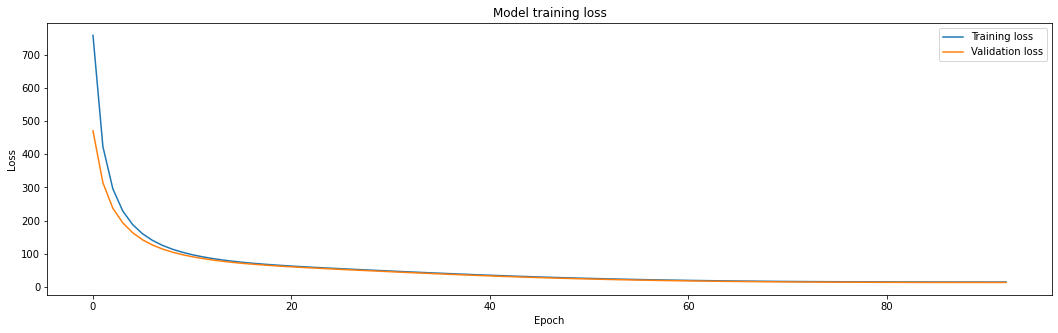

In [15]:
plt.figure(figsize=(18, 5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.yscale('log')

plt.show()

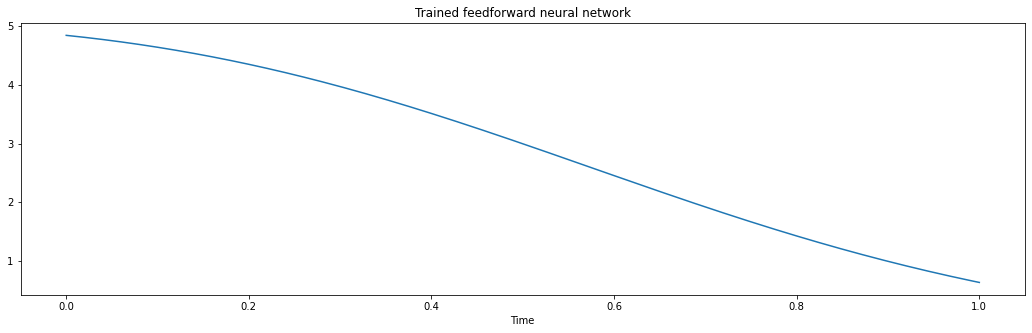

In [16]:
learnedstrat = model_best.predict(t_test, verbose = 0)

plt.figure(figsize=(18, 5))
plt.plot(t_test, learnedstrat)
plt.title("Trained feedforward neural network")
plt.xlabel("Time")
plt.show()


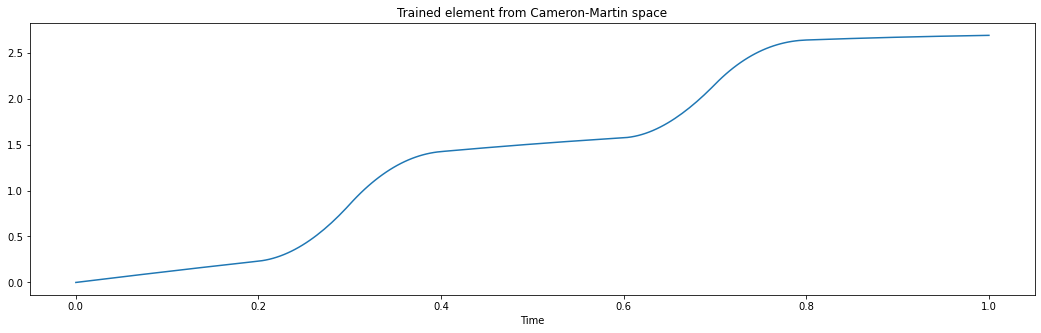

In [17]:
# Visualizing the drift

normdrift = 0
driftdummy = np.zeros((1))
drift = np.zeros((N_test+1))
driftdelta = np.zeros((N_test))

for j in range(N_test):
    normdrift += learnedstrat[j]**2 * vec_A_helper_test[j]
    driftdelta[j] = learnedstrat[j] * vec_A_helper_test[j]
    driftdummy += learnedstrat[j] * vec_A_helper_test[j]
    drift[j+1] = driftdummy

plt.figure(figsize=(18, 5))

plt.plot(t_test, drift)
plt.title("Trained element from Cameron-Martin space")
plt.xlabel("Time")
plt.show()


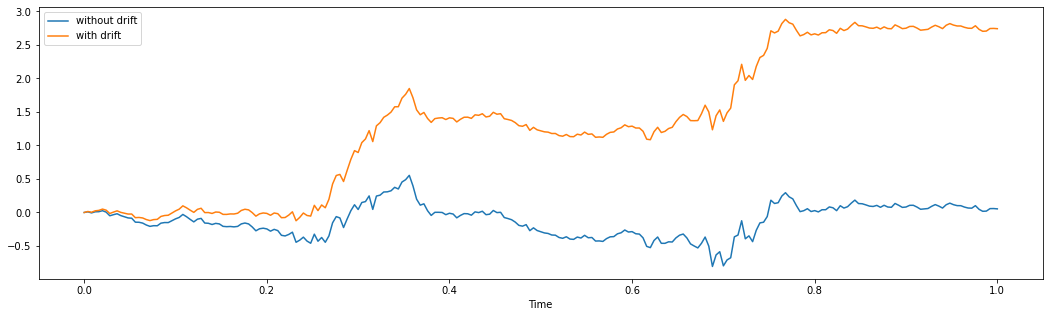

In [18]:
M = np.sqrt(vec_A_helper_test) * np.random.normal(0, 1, (N_test))

M_MC = np.cumsum(np.concatenate([np.zeros((1)), M]))
M_IS = np.cumsum(np.concatenate([np.zeros((1)), M + driftdelta]))

plt.figure(figsize=(18, 5)) 
plt.plot(t_test, np.transpose(M_MC), label="without drift")
plt.plot(t_test, np.transpose(M_IS), label="with drift")
plt.xlabel("Time")
plt.legend()
plt.show()


## Computing option prices (MC, IS, Strat)

In [19]:
N_strata = 100

N_replications = int(N_NN_test / N_strata)

DATA_test_MC_IS = np.zeros((N_NN_test, N_test))
DATA_test_Strat = np.zeros((N_NN_test, N_test))

for i in range(N_strata):
    
    M_random = np.random.normal(0, 1, (N_replications, N_test))
    V_master = np.random.uniform(0, 1, (N_replications))
    
    ### MC and IS 
    u = np.ones((N_test)) / N_test
    
    V = i / N_strata + V_master / N_strata
    V = norm.ppf(V)
    
    Y = M_random
    
    sum_1 = np.multiply(np.ones((N_replications, N_test))*u, V[:, None])
    sum_2 = Y
    sum_3 = np.multiply(np.ones((N_replications, N_test))*u, Y.dot(u)[:, None])
    
    Z = sum_1 + sum_2 - sum_3
    
    DATA_test_MC_IS[(i*N_replications):((i+1)*N_replications), :] = Z
    
    ### Strat
    driftdelta_scaled = driftdelta / np.sqrt(vec_A_helper_test) 
    u = driftdelta_scaled / np.sqrt(driftdelta_scaled.dot(driftdelta_scaled))
    
    V = i / N_strata + V_master / N_strata
    V = norm.ppf(V)
    
    Y = M_random
    
    sum_1 = np.multiply(np.ones((N_replications, N_test))*u, V[:, None])
    sum_2 = Y
    sum_3 = np.multiply(np.ones((N_replications, N_test))*u, Y.dot(u)[:, None])
    
    Z = sum_1 + sum_2 - sum_3
    
    DATA_test_Strat[(i*N_replications):((i+1)*N_replications), :] = Z


In [20]:
### Monte Carlo estimate

M_random = np.sqrt(vec_A_helper_test) * DATA_test_MC_IS

M_MC = np.concatenate([np.zeros((N_NN_test, 1)), M_random], axis = 1)
M_MC = np.cumsum(M_MC, axis = 1)
X_MC = X0 * np.exp((mu - sigma**2/2)*vec_A_test + sigma * M_MC)
X_MC = X_MC[:, :N_test]

average = np.sum(X_MC * delta_t_test, axis = 1) / T
call_MC = 100*np.clip(average-strike, 0, None)

counter_MC = np.sum(average-strike >= 0) / N_NN_test * 100

In [21]:
### Importance sampling estimate

M_0 = M_random + driftdelta

M_IS = np.concatenate([np.zeros((N_NN_test, 1)), M_0], axis = 1)
M_IS = np.cumsum(M_IS, axis = 1)
X_IS = X0 * np.exp((mu - sigma**2/2)*vec_A_test + sigma * M_IS)
X_IS = X_IS[:, :N_test]

C0 = np.sum(np.multiply(learnedstrat[:N_test].reshape((N_test)), M_0), axis = 1)
C1 = normdrift
adjustment = np.exp(-1*C0 + 0.5*C1)

average = np.sum(X_IS * delta_t_test, axis = 1) / T
call_IS = 100*np.clip(average-strike, 0, None) * adjustment

counter_IS = np.sum(average-strike >= 0) / N_NN_test * 100
    
variance_ratio_IS = np.var(call_MC) / np.var(call_IS)

In [22]:
### Stratification estimate

means_Strat = []
variances_Strat = []
counter_Strat = 0

for i in range(N_strata):
    
    Z = DATA_test_Strat[(i*N_replications):((i+1)*N_replications), :]
    
    M_0 = Z + driftdelta_scaled
    M_IS = np.concatenate([np.zeros((N_replications, 1)), np.sqrt(vec_A_helper_test) * M_0], axis = 1)
    M_IS = np.cumsum(M_IS, axis = 1)
    X_IS = X0 * np.exp((mu - sigma**2/2)*vec_A_test + sigma * M_IS)
    X_IS = X_IS[:, :N_test]
    
    C0 = np.sum(np.multiply(driftdelta_scaled.reshape((N_test)), M_0), axis = 1)
    C1 = normdrift
    adjustment = np.exp(-1*C0 + 0.5*C1)
    
    average = np.sum(X_IS * delta_t_test, axis = 1) / T
    call_Strat = 100*np.clip(average-strike, 0, None) * adjustment
    
    counter_Strat = counter_Strat + np.sum(average-strike >= 0)
    
    means_Strat = means_Strat + [np.mean(call_Strat)]
    variances_Strat = variances_Strat + [np.var(call_Strat)]
    
mean_Strat = 0
variance_Strat = 0

for i in range(N_strata):
    mean_Strat += 1/N_strata * means_Strat[i]
    variance_Strat = variance_Strat + (1/N_strata)**2 * variances_Strat[i] / N_replications

call_Strat = mean_Strat
variance_ratio_Strat = np.var(call_MC) / N_NN_test / variance_Strat

counter_Strat = counter_Strat / N_NN_test * 100
    

In [23]:
### RESULTS 

print("========================================")

print("MC estimate: ", np.around(np.mean(call_MC), 8))
print("IS estimate: ", np.around(np.mean(call_IS), 8))
print("ST estimate: ", np.around(call_Strat, 8))

print("========================================")

print("Standard error (MC): ", np.around(np.std(call_MC) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(call_MC) / np.sqrt(N_NN_test) / np.mean(call_MC) * 100, 8), "% )")
print("Standard error (IS): ", np.around(np.std(call_IS) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(call_IS) / np.sqrt(N_NN_test) / np.mean(call_IS) * 100, 8), "% )")
print("Standard error (ST): ", np.around(np.sqrt(variance_Strat), 8), " (", np.around(np.sqrt(variance_Strat) / np.sqrt(N_NN_test) / call_Strat * 100, 8), "% )")

print("========================================")

print("Variance ratio IS: ", np.around(variance_ratio_IS))
print("Variance ratio ST: ", np.around(variance_ratio_Strat))

print("========================================")

print("Probability of positive payoff (MC): ", np.around(counter_MC, 4), "%")
print("Probability of positive payoff (IS): ", np.around(counter_IS, 4), "%")
print("Probability of positive payoff (ST): ", np.around(counter_Strat, 4), "%")


MC estimate:  2.35847543
IS estimate:  2.53791497
ST estimate:  2.530106
Standard error (MC):  0.12023036  ( 5.09780014 % )
Standard error (IS):  0.00858853  ( 0.33840899 % )
Standard error (ST):  0.00185052  ( 0.00023129 % )
Variance ratio IS:  196.0
Variance ratio ST:  4221.0
Probability of positive payoff (MC):  0.74 %
Probability of positive payoff (IS):  67.681 %
Probability of positive payoff (ST):  67.661 %
